# Exploratory Data Analysis

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math
from models import METAINFO, id_labels

In [2]:
PATH = 'dataset/'
def get_dfs():
    train_df = pd.read_csv(PATH + 'train.csv')
    val_df   = pd.read_csv(PATH + 'val.csv'  )
    test_df  = pd.read_csv(PATH + 'test.csv' )
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs()

In [3]:
import os
BIN_PATH = 'bin/'
if not os.path.exists(BIN_PATH):
    os.makedirs(BIN_PATH)

# 1. Basic Analyses

### 1.1. Invalid value check

In [412]:
def print_invalid_summary(df, invalid_type, set_name):
    if invalid_type == "null":
        df_check = df.isnull()
    elif invalid_type == "nan":
        df_check = df.isna()
    else:
        df_check = (df == '')
        invalid_type = "empty entry"
    print(f'{set_name.capitalize()} set {invalid_type} summary')
    print(df_check.sum())
    print()

print_invalid_summary(train_df, "null", "train")
print_invalid_summary(val_df  , "null", "val"  )
print_invalid_summary(test_df , "null", "test" )

Train set null summary
id            0
im_path       0
label_path    0
dtype: int64

Val set null summary
id            0
im_path       0
label_path    0
dtype: int64

Test set null summary
id            0
im_path       0
label_path    0
dtype: int64



In [410]:
print_invalid_summary(train_df, "nan", "train")
print_invalid_summary(val_df  , "nan", "val"  )
print_invalid_summary(test_df , "nan", "test" )

Train set nan summary
id            0
im_path       0
label_path    0
dtype: int64

Val set nan summary
id            0
im_path       0
label_path    0
dtype: int64

Test set nan summary
id            0
im_path       0
label_path    0
dtype: int64



In [411]:
print_invalid_summary(train_df, "", "train")
print_invalid_summary(val_df  , "", "val"  )
print_invalid_summary(test_df , "", "test" )

Train set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64

Val set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64

Test set empty entry summary
id            0
im_path       0
label_path    0
dtype: int64



### 1.2. Invalid file directory check

In [4]:
def file_exist(file_paths):
    for fp in file_paths:
        directory = os.path.dirname(fp)
        if not os.path.exists(directory):
            return False
    return True

def df_check_file_exist(df):
    im_path = np.array(df['im_path'])
    label_path = np.array(df['label_path'])
    return file_exist(im_path) and file_exist(label_path)

def id_matching(df):
    # check whether id matches im_path and label_path file names
    paths_lst = [
        np.array(df['id']), np.array(df['im_path']), np.array(df['label_path'])
    ]
    filenames = [None] * len(paths_lst)
    extract_subdirectory = np.vectorize(
        lambda paths, delim: np.char.split(paths, delim)
    )
    remove_extension = np.vectorize(
        lambda fn: fn[:fn.rfind('.')] if '.' in fn else fn
    )
    for i, paths in enumerate(paths_lst):
        split_paths  = extract_subdirectory(paths, '/')
        fn = np.array([path.tolist()[-1] for path in split_paths])
        fn = remove_extension(fn)
        filenames[i] = fn
    filenames = np.array(filenames)
    match_arr = (filenames == filenames[0]).all(axis=0)
    return np.all(match_arr)

#### File directory existence check

In [370]:
print(f'All file directories exist in Train: {df_check_file_exist(train_df)}')
print(f'All file directories exist in Val  : {df_check_file_exist(val_df  )}')
print(f'All file directories exist in Test : {df_check_file_exist(test_df )}')

All file directories exist in Train: True
All file directories exist in Val  : True
All file directories exist in Test : True


#### ID matching check

In [380]:
print(f'All IDs are matched in Train: {id_matching(train_df)}')
print(f'All IDs are matched in Val  : {id_matching(val_df  )}')
print(f'All IDs are matched in Test : {id_matching(test_df )}')

All IDs are matched in Train: True
All IDs are matched in Val  : True
All IDs are matched in Test : True


### 1.3. Duplicates check

In [384]:
print(f'Duplicate count of train set: {train_df.duplicated().sum()}')
print(f'Duplicate count of val   set: {val_df  .duplicated().sum()}')
print(f'Duplicate count of test  set: {test_df .duplicated().sum()}')

Duplicate count of train set: 0
Duplicate count of val   set: 0
Duplicate count of test  set: 0


### 1.4. Data Leakage

#### **Entry leakage check**

Since we have verified that all IDs matched up, all we need to do is compare the IDs of 1 dataset against the other.

In [396]:
def entry_unique(df1, df2):
    ids1 = np.array(df1['id'])
    ids2 = np.array(df2['id'])
    return len(np.intersect1d(ids1, ids2))

print(f'Train and Test has {entry_unique(train_df, test_df)} shared entries')
print(f'Train and Val  has {entry_unique(train_df, val_df )} shared entries')
print(f'Test  and Val  has {entry_unique(test_df , val_df )} shared entries')

Train and Test has 0 shared entries
Train and Val  has 0 shared entries
Test  and Val  has 0 shared entries


#### **Image leakage check**

Another thing we must check is whether if there are any duplicated **images** across datasets. Furthermore, we should calculate the correlation between every pair of every image from different datasets. If there are many highly-correlated images in the dataset, the leakage issue must be appropriately addressed.

In [5]:
def dataset_correlation(df1, df2, col='im_path', threshold=0.85):
    im_paths1 = np.array(df1[col])
    im_paths2 = np.array(df2[col])
    scores = np.zeros((im_paths1.shape[0], 2))
    for i, ip1 in enumerate(im_paths1):
        corrs = np.zeros((im_paths2.shape[0],))
        img1 = cv2.imread(ip1)
        img1 = img1.flatten()
        for j, ip2 in enumerate(im_paths2):
            img2 = cv2.imread(ip2)
            img2 = img2.flatten()
            corr = np.corrcoef(img1, img2)[0, 1]
            corrs[j] = corr
        # threshold shows at which point correlation is considered large
        scores[i] = np.array([
            np.max(corrs), len(corrs[corrs > threshold])
        ])
    return scores

def stochastic_dataset_correlation(df1, df2, col='im_path', n=2, threshold=0.85):
    im_paths1 = np.array(df1[col])
    im_paths2 = np.array(df2[col])
    scores = np.zeros((im_paths1.shape[0], 2))
    for i, ip1 in enumerate(im_paths1):
        img1 = cv2.imread(ip1)
        img1 = img1.flatten()
        # randomly pick n entries from the other dataset
        corrs = np.zeros((n,))
        random_entries = np.random.choice(im_paths2, size=n, replace=False)
        for j, ip2 in enumerate(random_entries):
            img2 = cv2.imread(ip2)
            img2 = img2.flatten()
            corr = np.corrcoef(img1, img2)[0, 1]
            corrs[j] = corr
        # threshold shows at which point correlation is considered large
        scores[i] = np.array([
            np.max(corrs), len(corrs[corrs > threshold])
        ])
    return scores

def print_correlations(scores, df1_name, df2_name, threshold):
    round_4      = lambda x: round(x, 4)
    df1_name     = df1_name.capitalize()
    df2_name     = df2_name.capitalize()
    max_scores   = scores[:,0]
    total_exceed = round_4(np.sum(scores[:,1]))
    mean_max     = round_4(np.mean(max_scores))
    med_max      = round_4(np.median(max_scores))
    max_score    = round_4(np.max(max_scores))
    title        = (
        f'Summary of correlation between {df1_name} and {df2_name} '
        f'(t = {threshold})'
    )
    print(f'{title}\n{'-'*len(title)}')
    print(f'Total number of correlations exceeding t     : {total_exceed}')
    print(f'Mean of all maximum pairwise correlations    : {mean_max}')
    print(f'Median of all maximum pairwise correlations  : {med_max}')
    print(f'Maximum of all maximum pairwise correlations : {max_score}')

#### Correlation summary between Test and Train

In [ ]:
corr_threshold = 0.85
corr_train_test = stochastic_dataset_correlation(train_df, test_df, threshold=corr_threshold)

In [545]:
print_correlations(corr_train_test, "train", "test", corr_threshold)

Summary of correlation between Train and Test (t = 0.85)
--------------------------------------------------------
Total number of correlations exceeding t     : 0.0
Mean of all maximum pairwise correlations    : 0.2821
Median of all maximum pairwise correlations  : 0.2765
Maximum of all maximum pairwise correlations : 0.7903


#### Correlation summary between Val and Train

In [ ]:
corr_threshold = 0.85
corr_val_test = stochastic_dataset_correlation(val_df, test_df, threshold=corr_threshold)

In [546]:
print_correlations(corr_val_test, "val", "test", corr_threshold)

Summary of correlation between Val and Test (t = 0.85)
------------------------------------------------------
Total number of correlations exceeding t     : 0.0
Mean of all maximum pairwise correlations    : 0.3082
Median of all maximum pairwise correlations  : 0.3136
Maximum of all maximum pairwise correlations : 0.7755


#### **Commentary**

There is no data leakage, as suggested by:
* No duplicate entries across datasets
* Relatively low correlation between any 2 datasets

# 2. Distribution Analysis

### Plotting helpers

In [100]:
def plot_distribution(distribution, title, classes, log=True, save=True):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution, tick_label=[
        f'{classes[i]}' for i in range(len(distribution))
    ])
    plt.title(title)
    plt.xticks(rotation=75)
    y_label = 'Frequency'
    if log:
        y_label += ' (log scale)'
        plt.yscale('log')
    if save:
        plt.savefig(BIN_PATH + title)
    plt.xlabel('Class')
    plt.ylabel(y_label)
    plt.show()


def plot_multiple_distributions(
    folder_labels, title, subtitles, labels,
    log=True, x_axis_factor=None, y_axis_factor=1, font_factor=1,
    sharey=False, save=True
):
    # row, column, and factoring
    total = len(folder_labels)
    cols  = 2
    rows  = total//cols + 1 if total > cols else 1
    if x_axis_factor is None:
        x_axis_factor = 2.2 if rows == 1 else 1.2*(rows-1)

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(15*x_axis_factor, 15*y_axis_factor), sharey=sharey
    )
    title = f'{title} (log-scaled)' if log else title
    fig.suptitle(title, fontsize=25*font_factor)
    y_label = 'Frequency (log scale)' if log else 'Frequency'
    fig.text(0.5, 0.04, 'Class', ha='center', fontsize=15)
    fig.text(0.06, 0.5, y_label, va='center', rotation='vertical', fontsize=15)

    # legend
    legend_labels  = [f'{i}: {labels[i]}' for i in range(len(labels))]
    legend_handles = [plt.Rectangle((0,0), 0, 0, alpha=0.0) for _ in labels]
    fig.legend(
        legend_handles, legend_labels, loc='lower right', prop={'size': 12}
    )

    # distribution for each folder
    for i in range(cols*rows):
        ax_i = ax[i] if rows == 1 else ax[i//cols, i%cols]
        if i >= total:
            ax_i.axis('off')
            continue # leave blank rather than stop
        distribution = folder_labels[i]
        ax_i.bar(range(len(distribution)), distribution, tick_label=[
            f'{i}' for i in range(len(distribution))
        ])
        if log and np.any(distribution != 0):
            ax_i.set_yscale('log')
        ax_i.set_title(subtitles[i], fontsize=17*font_factor)

    if save:
        fig.savefig(BIN_PATH + title)

### Label distribution helpers

In [7]:
def label_arr(df):
    return np.array(df['label_path'])

def label_distributions(classes, path=None, arr=None):
    assert not path is None or not arr is None
    n = len(classes)
    labels = np.zeros((n,))
    if type(arr) != np.ndarray:
        arr = np.array(arr)
    paths = arr if path is None else os.listdir(path)
    for i, label_path in enumerate(paths):
        label = cv2.imread(label_path, -1)
        labels += np.bincount(label.flatten(), minlength=n)
    return labels


# Specific to folder distribution
def filter_by_subdirectories(paths, subdirectories, indx=1, delim='/'):
    ret = [None] * len(subdirectories)
    extract_subdirectory = np.vectorize(
        lambda paths, delim: np.char.split(paths, delim)
    )
    split_paths = extract_subdirectory(paths, delim)
    subdir_arr  = np.array([path.tolist()[indx] for path in split_paths])
    for i, subdirectory in enumerate(subdirectories):
        ret[i] = paths[subdir_arr == subdirectory]
    return ret

## 2.1. Global distributions

In [8]:
val_labels     = label_distributions(METAINFO['classes'], arr=label_arr(val_df  ))
train_labels   = label_distributions(METAINFO['classes'], arr=label_arr(train_df))
test_labels    = label_distributions(METAINFO['classes'], arr=label_arr(test_df ))
dataset_labels = val_labels + train_labels + test_labels

### **Training label distribution**

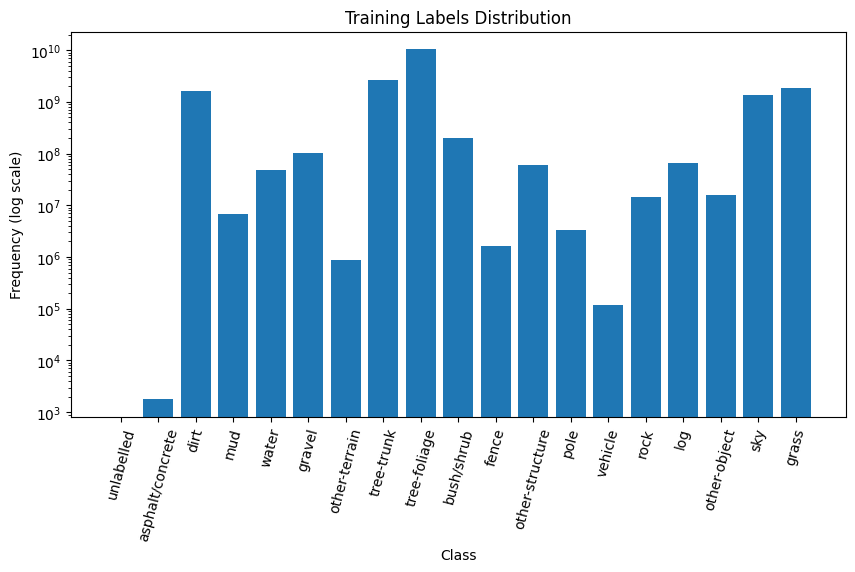

In [6]:
plot_distribution(train_labels, 'Training Labels Distribution', METAINFO['classes'])

### **Validating label distribution**

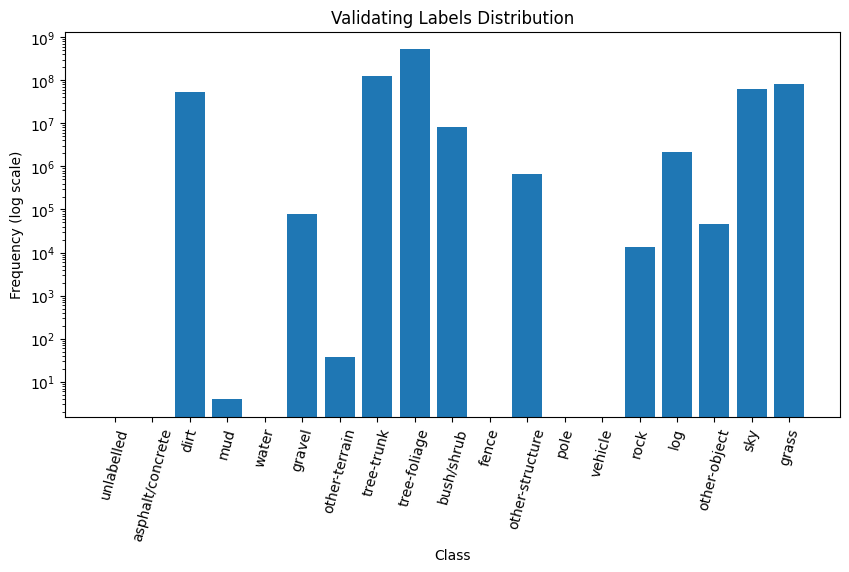

In [7]:
plot_distribution(val_labels, 'Validating Labels Distribution', METAINFO['classes'])

### **Testing label distribution**

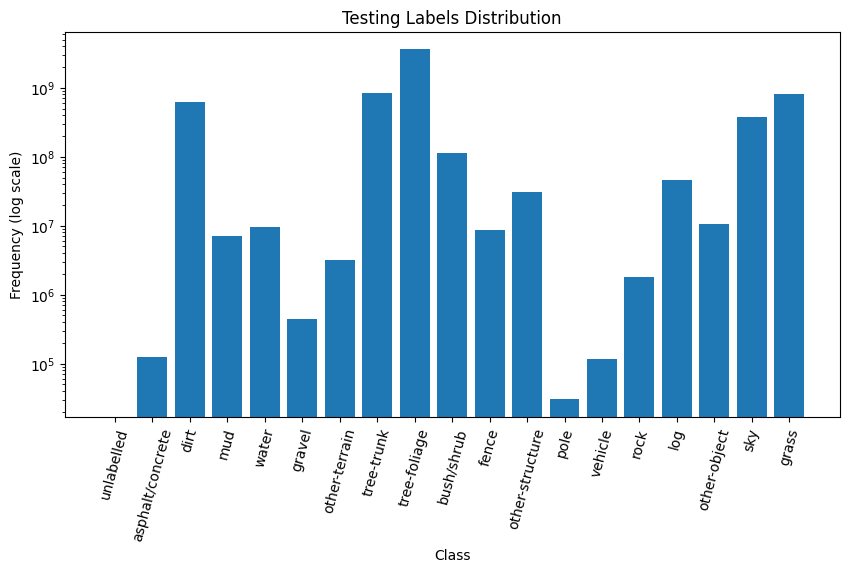

In [8]:
plot_distribution(test_labels, 'Testing Labels Distribution', METAINFO['classes'])

### **Dataset label distribution**

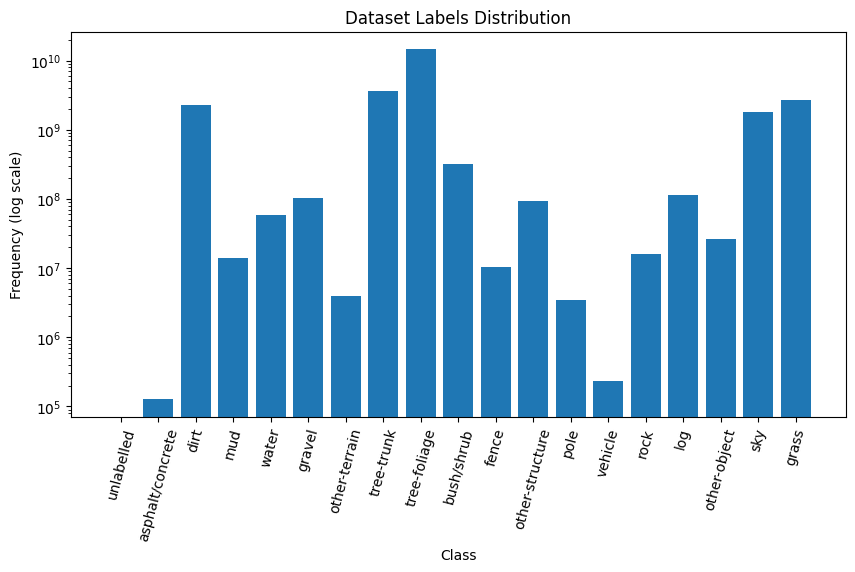

In [9]:
plot_distribution(dataset_labels, 'Dataset Labels Distribution', METAINFO['classes'])

### Commentary

Should be on how the split retains the dataset distribution among each subset (and possibly that it is indeed random, if it can even be proven - or at least a split process should be cited), especially train - since retaining distribution in train meant that the training data is most representative of the original data. Testing set retaining the distribution is also important, since it meant the performance evaluation is also the most representative.

## 2.2. Folder distributions

In [11]:
def get_folder_labels(folders):
    folder_labels = [None] * len(folders)
    for i, folder in enumerate(folders):
        folder_labels[i] = label_distributions(METAINFO['classes'], arr=folder)
    return folder_labels

In [12]:
subdirectories = ['K-01', 'K-03', 'V-01', 'V-02', 'V-03']
train_folders = filter_by_subdirectories(np.array(train_df['label_path']), subdirectories)
val_folders   = filter_by_subdirectories(np.array(val_df  ['label_path']), subdirectories)
test_folders  = filter_by_subdirectories(np.array(test_df ['label_path']), subdirectories)

train_folder_labels = get_folder_labels(train_folders)
val_folder_labels   = get_folder_labels(val_folders  )
test_folder_labels  = get_folder_labels(test_folders )

id_labels = {i: e for i, e in enumerate(METAINFO['classes'])}

### **Training distribution by folder**

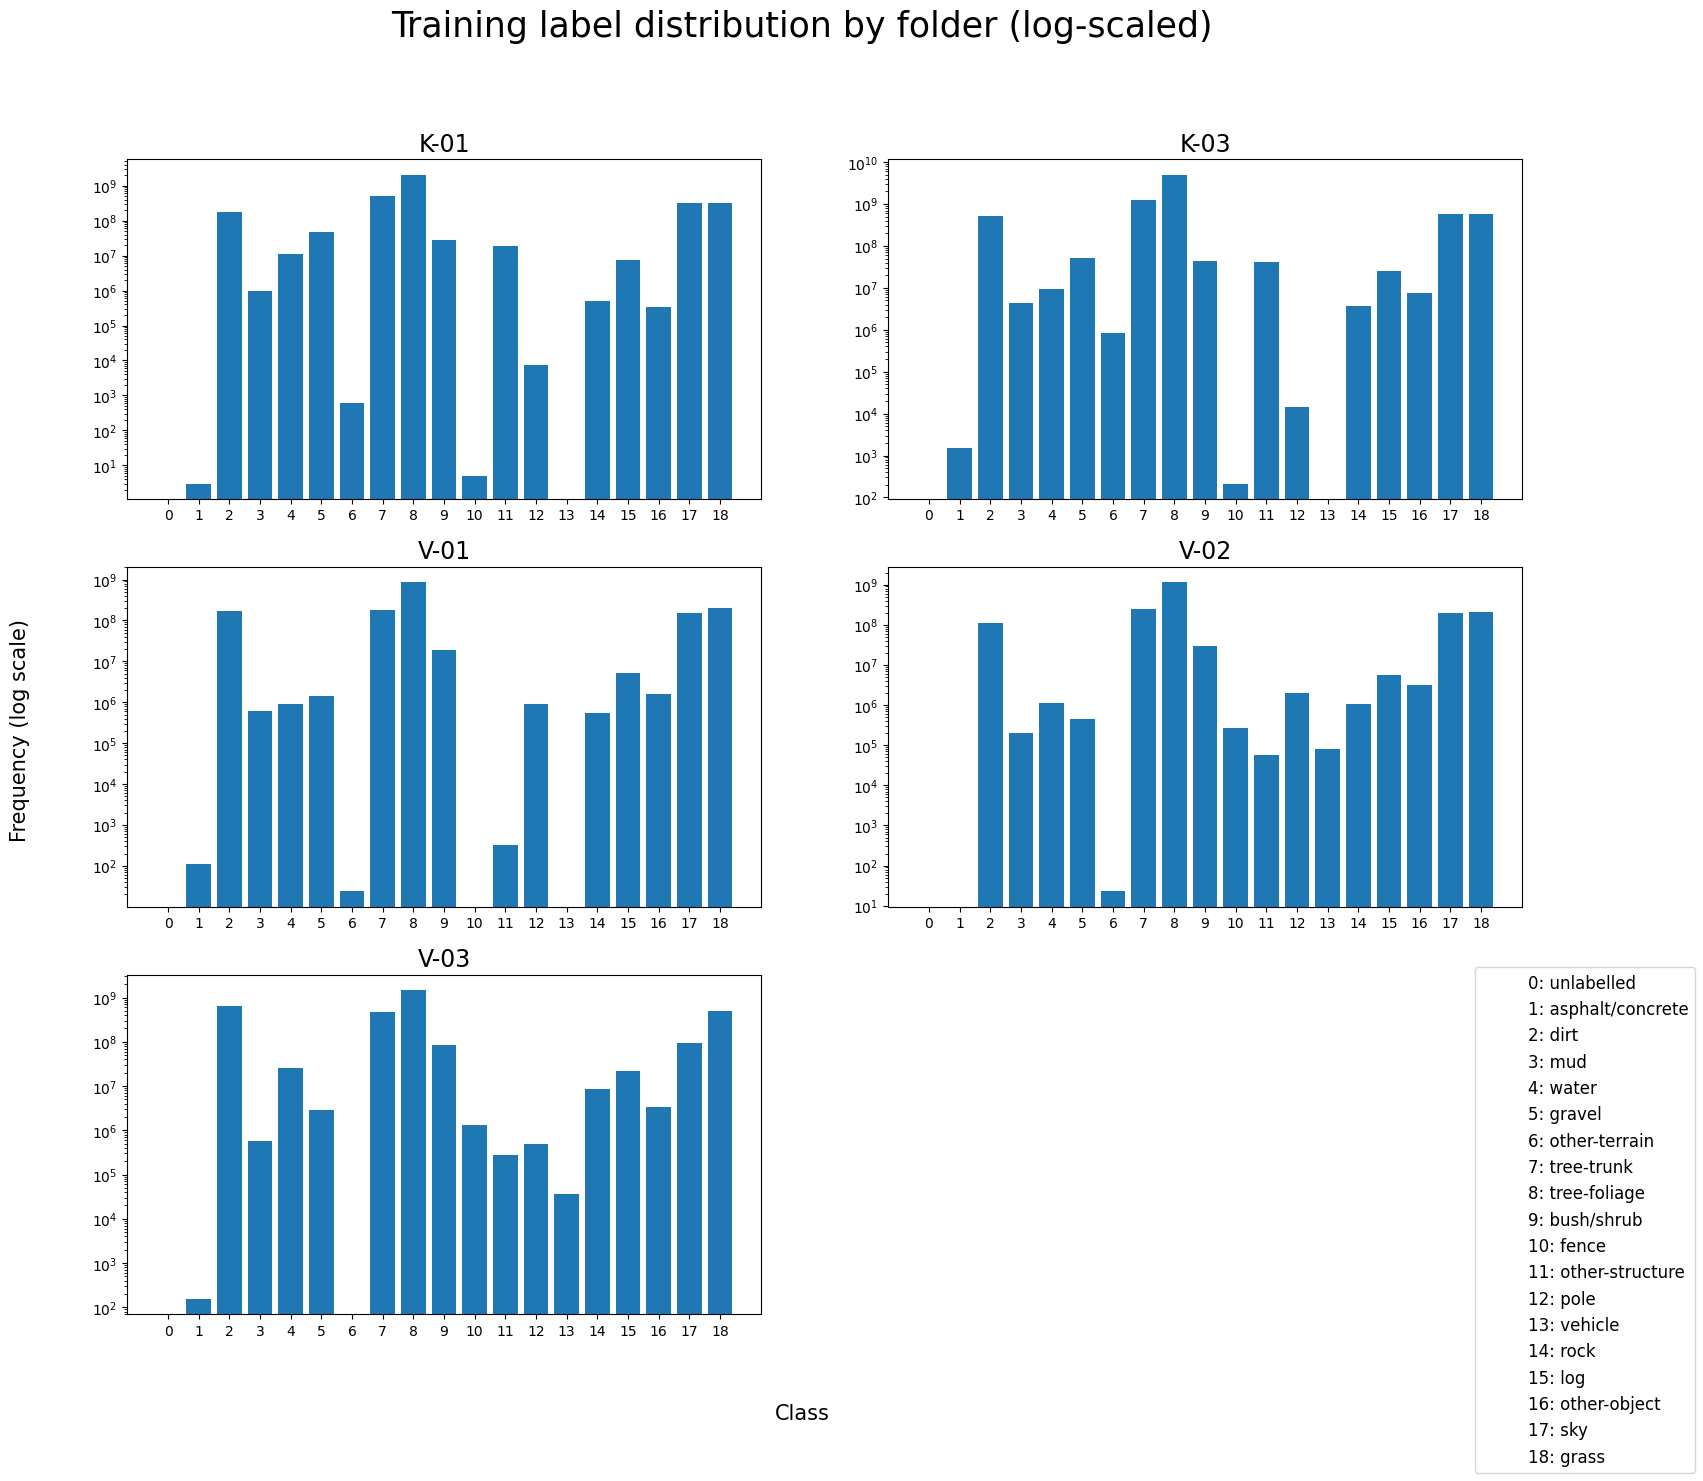

In [198]:
plot_multiple_distributions(
    train_folder_labels,
    "Training label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

### **Validating distribution by folder**

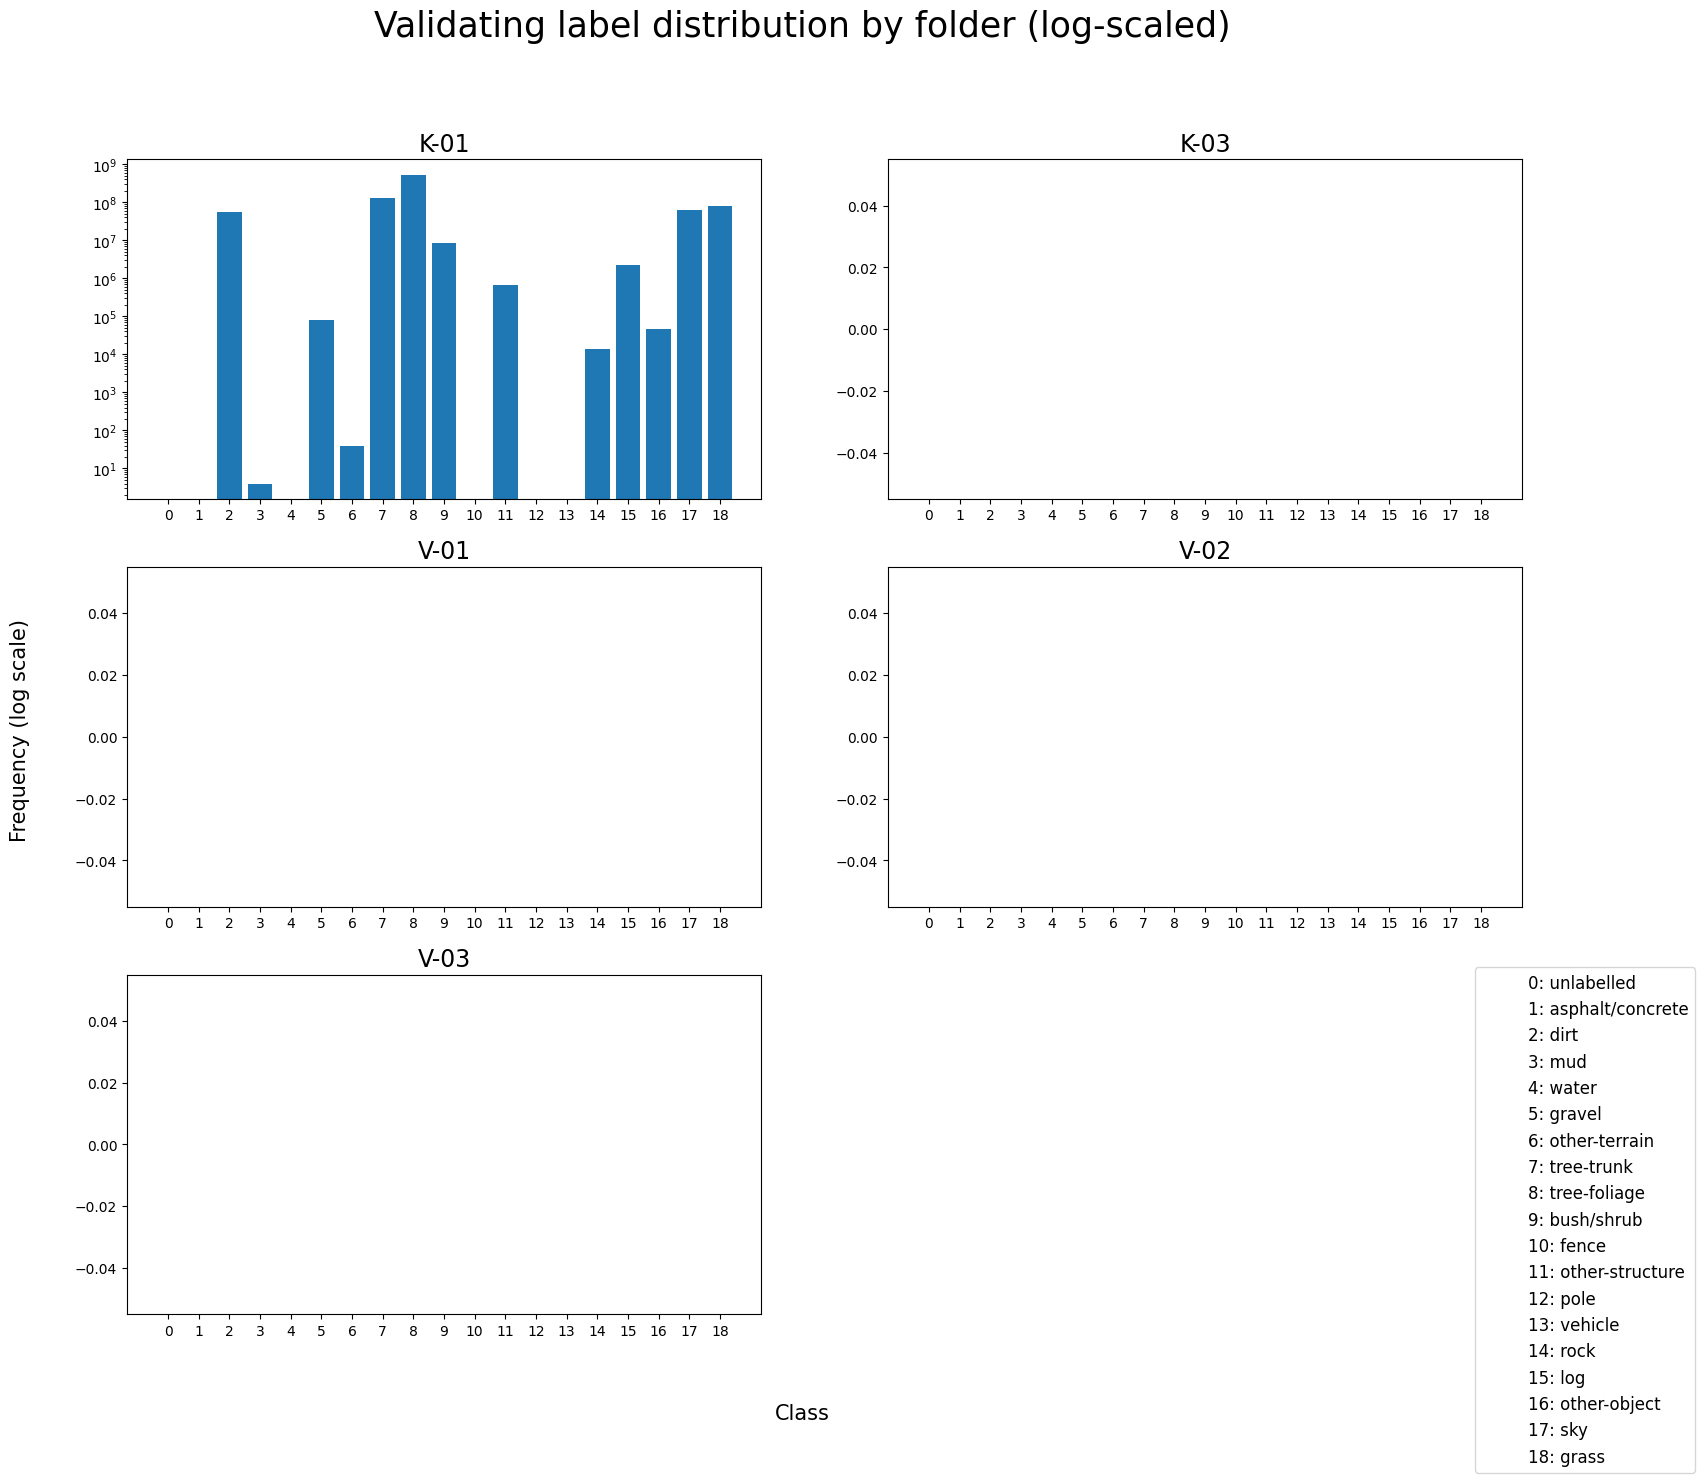

In [199]:
plot_multiple_distributions(
    val_folder_labels,
    "Validating label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

### **Testing distribution by folder**

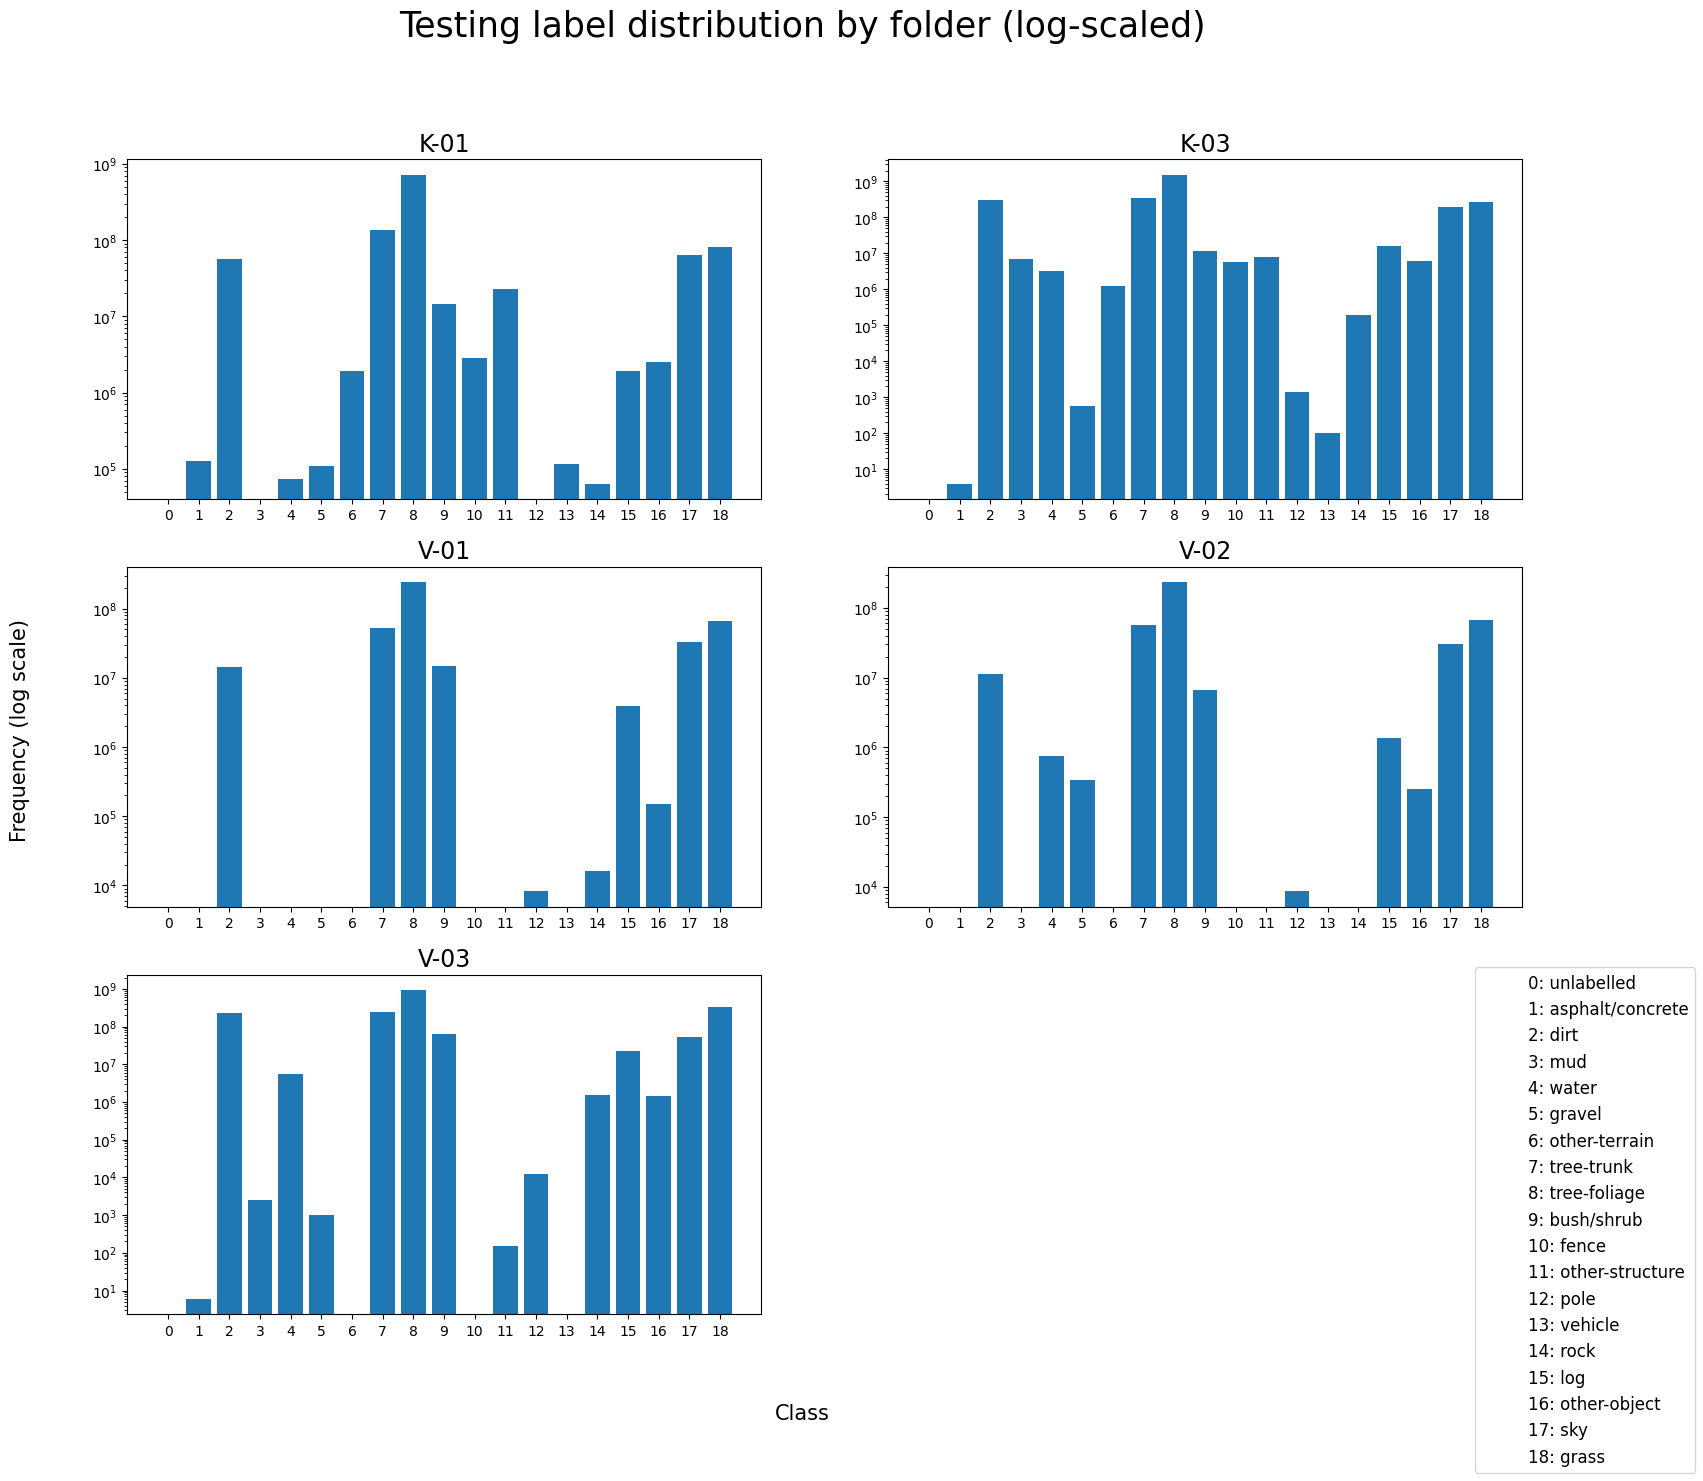

In [200]:
plot_multiple_distributions(
    test_folder_labels,
    "Testing label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

# 3. Train Sampling

### Stratified Sampling based on label distribution

In [9]:
def stratified_sampling(
    counts_array  ,  # array storing label counts of each image in dataset
    total_counts  ,  # array storing dataset's label count
    min_labels    ,  # labels to give 'leniency'
    sample_frac   ,  # sample size fraction
    min_frac=0.8  ,  # leniency fraction
    seed=100      ,  # random seed
    t=0.05        ,  # threshold to ignore split
):
    """
    Stratified sampling based on label count algorithm:
    For threshold argument t:
        if #label with min count < 0.05 #label with second least count
        we do not sample with fraction for said min label
    """
    min_frac = sample_frac if sample_frac > min_frac else min_frac
    min_labels = np.array(min_labels)
    sample_size = int(len(counts_array) * sample_frac)
    np.random.seed(seed)
    not_count = 0

    # calculate the proportion of each label for sample's desired label count
    total_labels = np.sum(total_counts)
    label_proportions = total_counts / total_labels
    if len(min_labels) > 0:
        label_proportions[min_labels] *= min_frac / sample_frac
    desired_label_counts = (label_proportions * sample_size).astype(int)
    selected_indices = []

    # for each label
    for i in range(counts_array.shape[1]):
        # indices of samples containing the label
        label_indices = np.where(counts_array[:, i] > 0)[0]

        # randomly sample (without replacement) instead
        if i in min_labels:
            not_count += int(len(label_indices) * sample_frac / min_frac)
        selected = np.random.choice(label_indices, size=desired_label_counts[i], replace=False)
        selected_indices.extend(selected)

    # Remove duplicates
    selected_indices = list(set(selected_indices))
    actual_count = len(selected_indices) - not_count//2
    
    # ensuring the desired number of samples
    if actual_count < sample_size:
        remaining_indices = list(set(range(len(counts_array))) - set(selected_indices))
        np.random.shuffle(remaining_indices)
        selected_indices.extend(remaining_indices[:sample_size - len(selected_indices)])
    return selected_indices

### Additional helpers

In [10]:
def get_y(arr):
    y = [None] * len(arr)
    if type(arr) != np.ndarray:
        arr = np.array(arr)
    for i, label_path in enumerate(arr):
        label = cv2.imread(label_path, -1)
        y[i]  = np.bincount(label.flatten(), minlength=NUM_CLASSES)
    return y


def print_sampling_labelwise_info(
    labels, labels_sampled, label_dict, min_labels, frac, min_frac, log=False
):
    title = "Log" if log else "Normal"
    print(f'\n{title}-scaled')
    columns = f'\t\t Original \tSampled \tScore'
    print('-'*(len(columns.replace('\t', ' '*8))+4))
    print(columns)
    set_tab1 = lambda s: '\t' if len(f'{s}') >= 7 else '\t\t'
    set_tab2 = lambda s: '\t' if len(f'{s}') >= 8 else '\t\t'

    labels_t = np.log1p(labels) if log else labels
    labels_sampled_t = np.log1p(labels_sampled) if log else labels_sampled

    # getting accuracy score helper functions
    rnd = lambda n: round(n, 4)
    def get_score(l, ls, is_min=False):
        f = min_frac if is_min else frac
        if l != 0:
            prop = (ls/l) / f
            return rnd((2 * (prop - 1)) / (prop + 1))
        else:
            return np.inf

    # for each label
    for i, label_name in label_dict.items():
        tabs = '\t\t ' if len(label_name) < 10 else '\t '
        if len(label_name) >= 16:
            tabs = ' '

        # get label count (l), label sampled count (ls)
        label = labels[i]
        label_t = labels_t[i]
        label_sampled = labels_sampled[i]
        label_sampled_t = labels_sampled_t[i]
        l  = rnd(label_t)
        ls = rnd(label_sampled_t)
        # score (s) is proportion of sample/original over desired proportion
        is_min = i in min_labels
        s = get_score(label, label_sampled, is_min)
        l_tabs  = set_tab1(l )
        ls_tabs = set_tab2(ls)
        if s >= 0:
            ls_tabs += ' '
        end = ' (*)' if is_min else ''
        print(f'{label_name}{tabs}{l}{l_tabs}{ls}{ls_tabs}{s}{end}')

    # total count and score
    l_sum   = rnd(np.sum(labels_t))
    ls_sum  = rnd(np.sum(labels_sampled_t))
    l_tabs  = set_tab1(l_sum )
    ls_tabs = set_tab2(ls_sum)
    s_sum   = get_score(np.sum(labels), np.sum(labels_sampled))
    print(f'Total\t\t {l_sum}{l_tabs}{ls_sum}{ls_tabs}{s_sum}')


def print_sampling_info(
    labels, labels_sampled, df_name, label_dict, min_labels, frac, min_frac=0.7,
    print_log=0, # 0 - print normal-scaled; 1 - log-scaled; else - both
):
    title = (
        f'Comparative label distribution between Original and Sampled '
        f'for {df_name} set (frac = {frac})'
    )
    print(title)
    print('=' * len(title))
    if print_log != 1:
        print_sampling_labelwise_info(
            labels, labels_sampled, label_dict, min_labels, frac, min_frac
        )
    if print_log != 0:
        print_sampling_labelwise_info(
            labels, labels_sampled, label_dict, min_labels, frac, min_frac, log=True
        )
    print()
    print("NOTE: Score shows how close the sample size is to the desired size, normalized in [-1,1].")
    print("(*) : Labels that got applied with higher proportion, and score reflects as such.")


def no_duplicates(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return len(unique[counts > 1]) == 0


# The purpose is just to not store huge arrays, and instead remove them
# as soon as function terminates
def get_labels_sampled(df, distribution, min_labels, frac, min_frac=0.7, col='label_path', seed=100):
    y = get_y(df[col])
    y = np.array(y)
    sampled_indx = stratified_sampling(y, distribution, min_labels, frac, seed=seed, min_frac=min_frac)
    assert no_duplicates(sampled_indx)
    sampled_data = label_arr(df)[sampled_indx]
    sample_dist = label_distributions(METAINFO['classes'], arr=sampled_data)
    return sample_dist, sampled_indx

### **Global Stratified Sampled Training**

In [11]:
NUM_CLASSES = 19
min_labels = [1]
train_labels_sampled, train_indx_sampled = get_labels_sampled(
    train_df, train_labels, min_labels, frac=0.3, min_frac=0.7, seed=10
)

In [14]:
print_sampling_info(train_labels, train_labels_sampled, "train", id_labels, min_labels, 0.3)

Comparative label distribution between Original and Sampled for train set (frac = 0.3)

Normal-scaled
-----------------------------------------------------------
		 Original 	Sampled 	Score
unlabelled	 0.0		0.0		 inf
asphalt/concrete 1794.0		1523.0		 0.1923 (*)
dirt		 1600840094.0	495633549.0	 0.0315
mud		 6857813.0	2482468.0	 0.1873
water		 48116742.0	16195210.0	 0.1149
gravel		 103405446.0	30172599.0	-0.0277
other-terrain	 860988.0	445420.0	 0.5318
tree-trunk	 2639454701.0	784375062.0	-0.0095
tree-foliage	 10507673624.0	3145758295.0	-0.0021
bush/shrub	 203633644.0	62244529.0	 0.0187
fence		 1620768.0	786437.0	 0.4718
other-structure	 60550301.0	18636590.0	 0.0256
pole		 3377421.0	967613.0	-0.0461
vehicle		 118755.0	46198.0		 0.2584
rock		 14315444.0	4502654.0	 0.0473
log		 65429710.0	20105284.0	 0.024
other-object	 15645583.0	5071732.0	 0.0774
sky		 1350206976.0	400659976.0	-0.0109
grass		 1822499988.0	544383341.0	-0.0043
Total		 18444609792.0	5532468480.0	-0.0002

NOTE: Score shows 

In [113]:
print_sampling_info(train_labels, train_labels_sampled, "train", id_labels, min_labels, 0.3)

Comparative label distribution between Original and Sampled for train set (frac = 0.3)

Normal-scaled
-----------------------------------------------------------
		 Original 	Sampled 	Score
unlabelled	 0.0		0.0		 inf
asphalt/concrete 1794.0		1523.0		 0.1923 (*)
dirt		 1600840094.0	495633549.0	 0.0315
mud		 6857813.0	2482468.0	 0.1873
water		 48116742.0	16195210.0	 0.1149
gravel		 103405446.0	30172599.0	-0.0277
other-terrain	 860988.0	445420.0	 0.5318
tree-trunk	 2639454701.0	784375062.0	-0.0095
tree-foliage	 10507673624.0	3145758295.0	-0.0021
bush/shrub	 203633644.0	62244529.0	 0.0187
fence		 1620768.0	786437.0	 0.4718
other-structure	 60550301.0	18636590.0	 0.0256
pole		 3377421.0	967613.0	-0.0461
vehicle		 118755.0	46198.0		 0.2584
rock		 14315444.0	4502654.0	 0.0473
log		 65429710.0	20105284.0	 0.024
other-object	 15645583.0	5071732.0	 0.0774
sky		 1350206976.0	400659976.0	-0.0109
grass		 1822499988.0	544383341.0	-0.0043
Total		 18444609792.0	5532468480.0	-0.0002

NOTE: Score shows 

### Log-scaled comparison

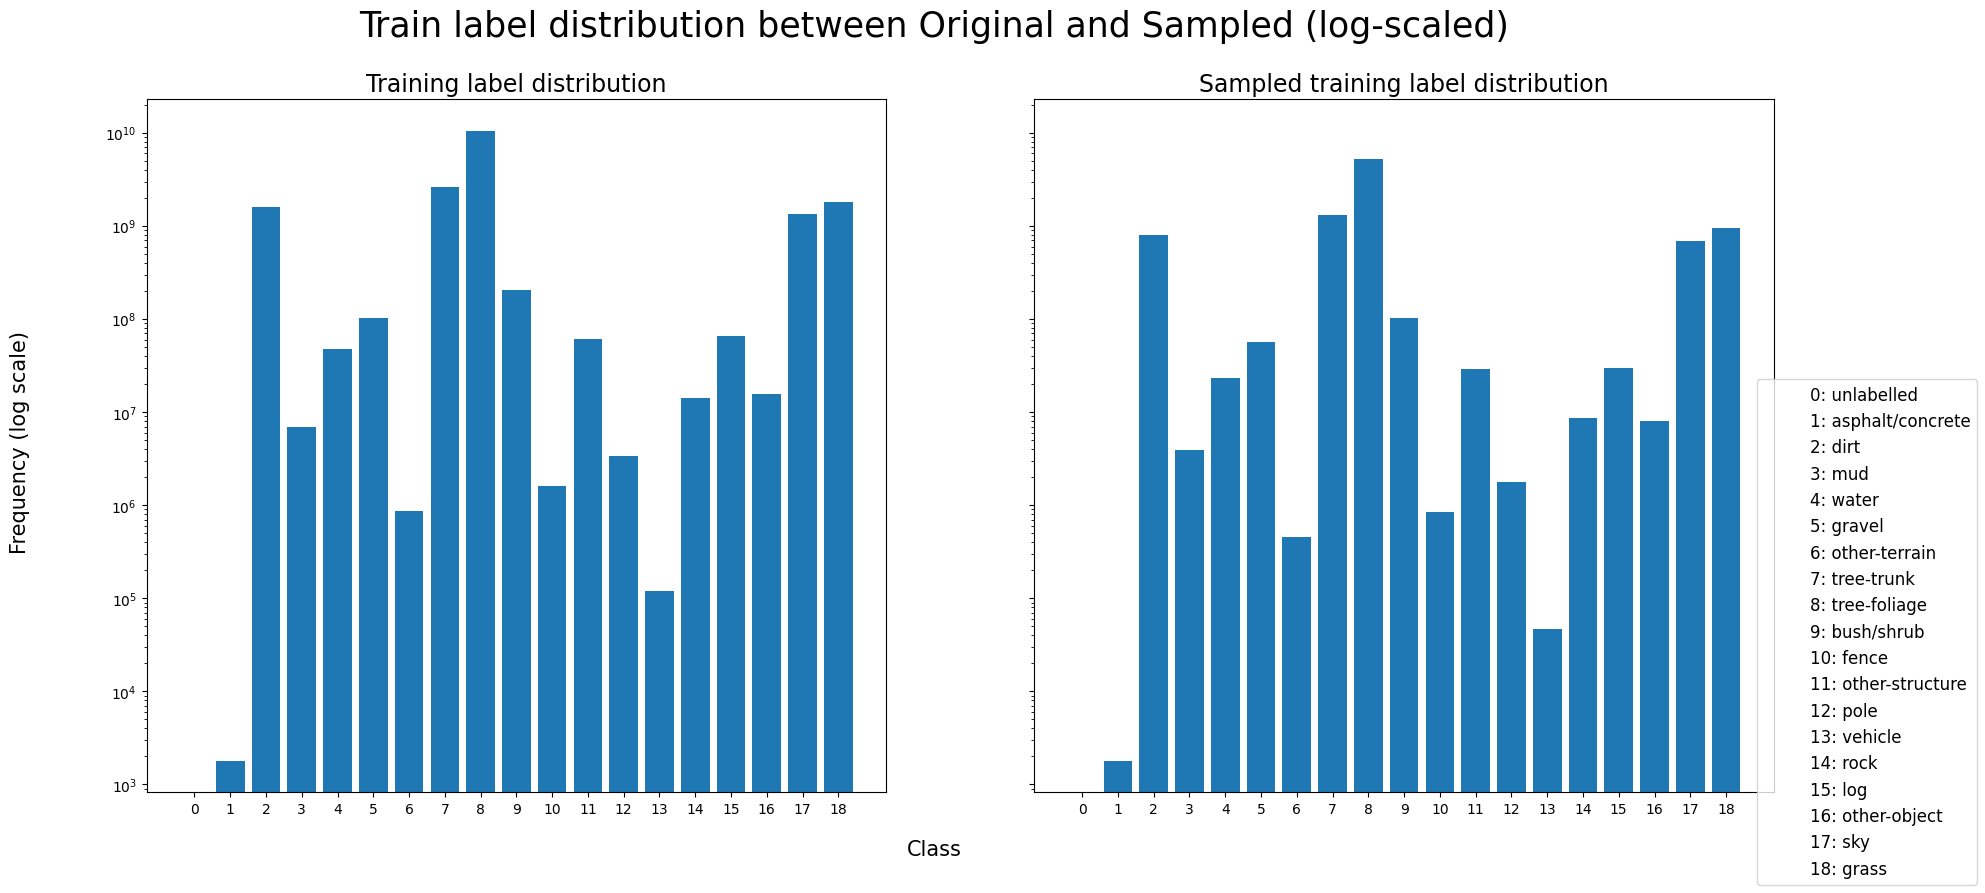

In [547]:
plot_multiple_distributions(
    [train_labels, train_labels_sampled],
    "Train label distribution between Original and Sampled",
    subtitles=["Training label distribution", "Sampled training label distribution"],
    labels=id_labels,
    x_axis_factor=1.4,
    y_axis_factor=0.6,
    sharey=True
)

### Normal-scaled comparison

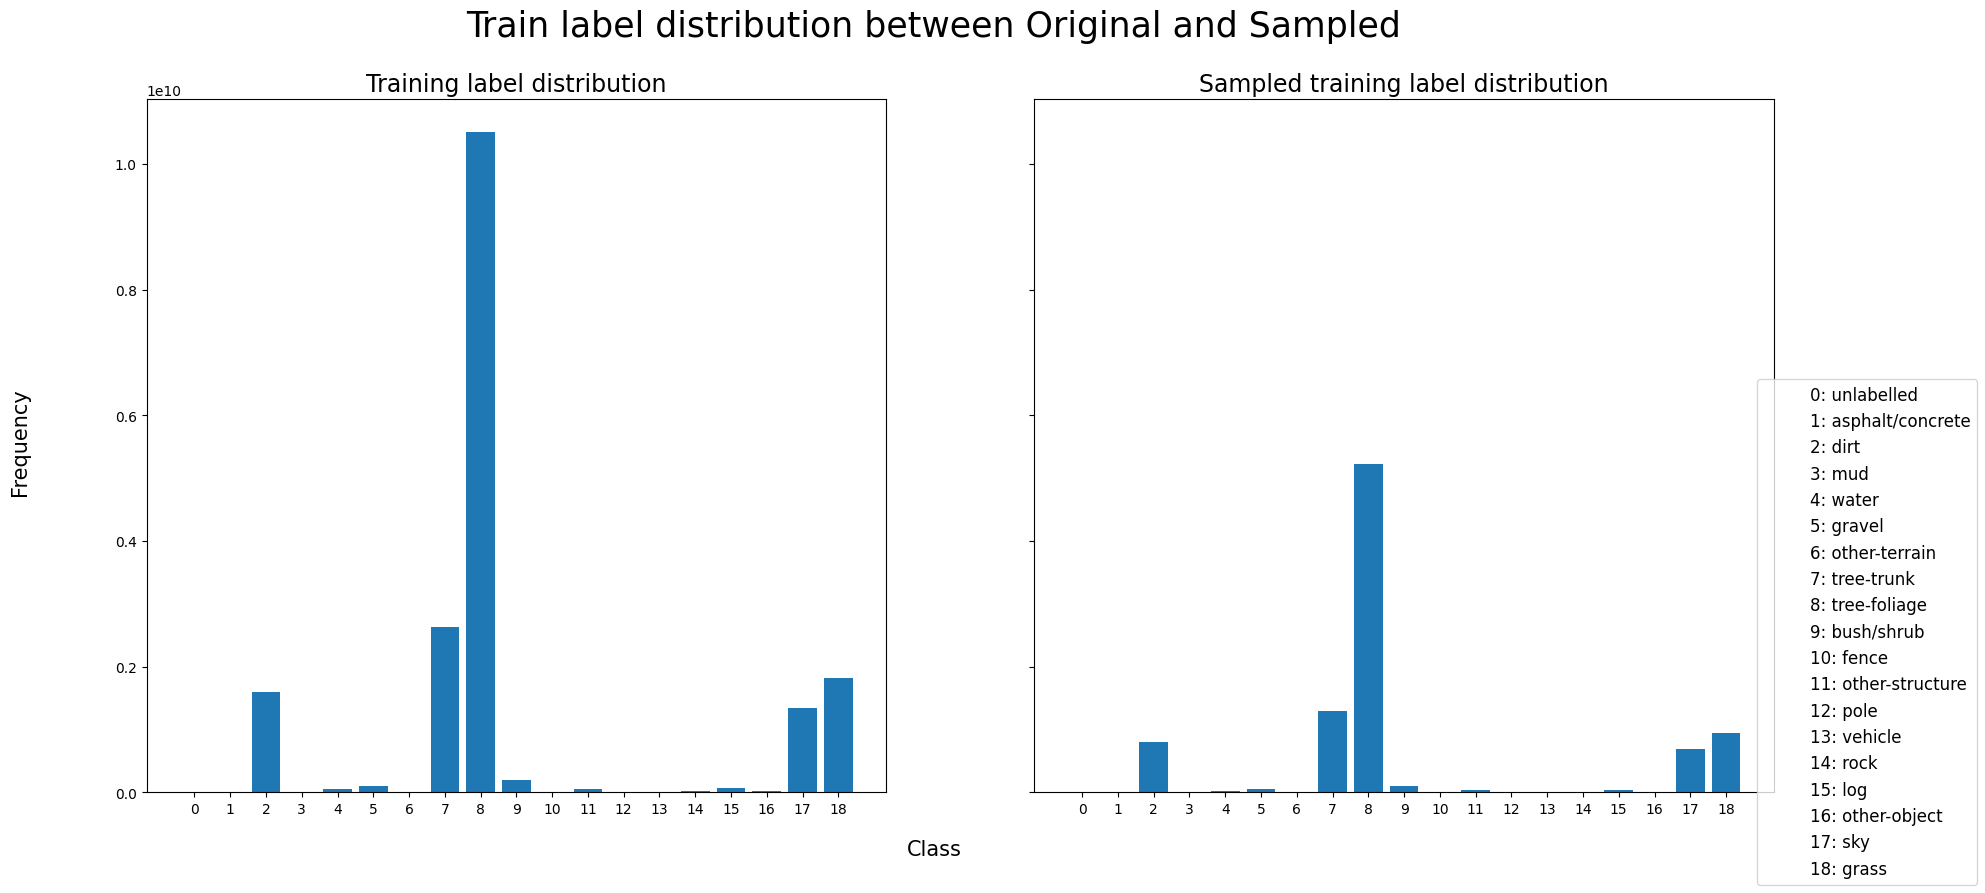

In [548]:
plot_multiple_distributions(
    [train_labels, train_labels_sampled],
    "Train label distribution between Original and Sampled",
    subtitles=["Training label distribution", "Sampled training label distribution"],
    labels=id_labels,
    x_axis_factor=1.4,
    y_axis_factor=0.6,
    log=False,
    sharey=True,
)

### **Folder Stratified Sampled Training**

In [ ]:
train_sample = np.array(train_df['label_path'])[train_indx_sampled]
train_folders_sampled = filter_by_subdirectories(train_sample, subdirectories)
train_folder_labels_sampled = get_folder_labels(train_folders_sampled)

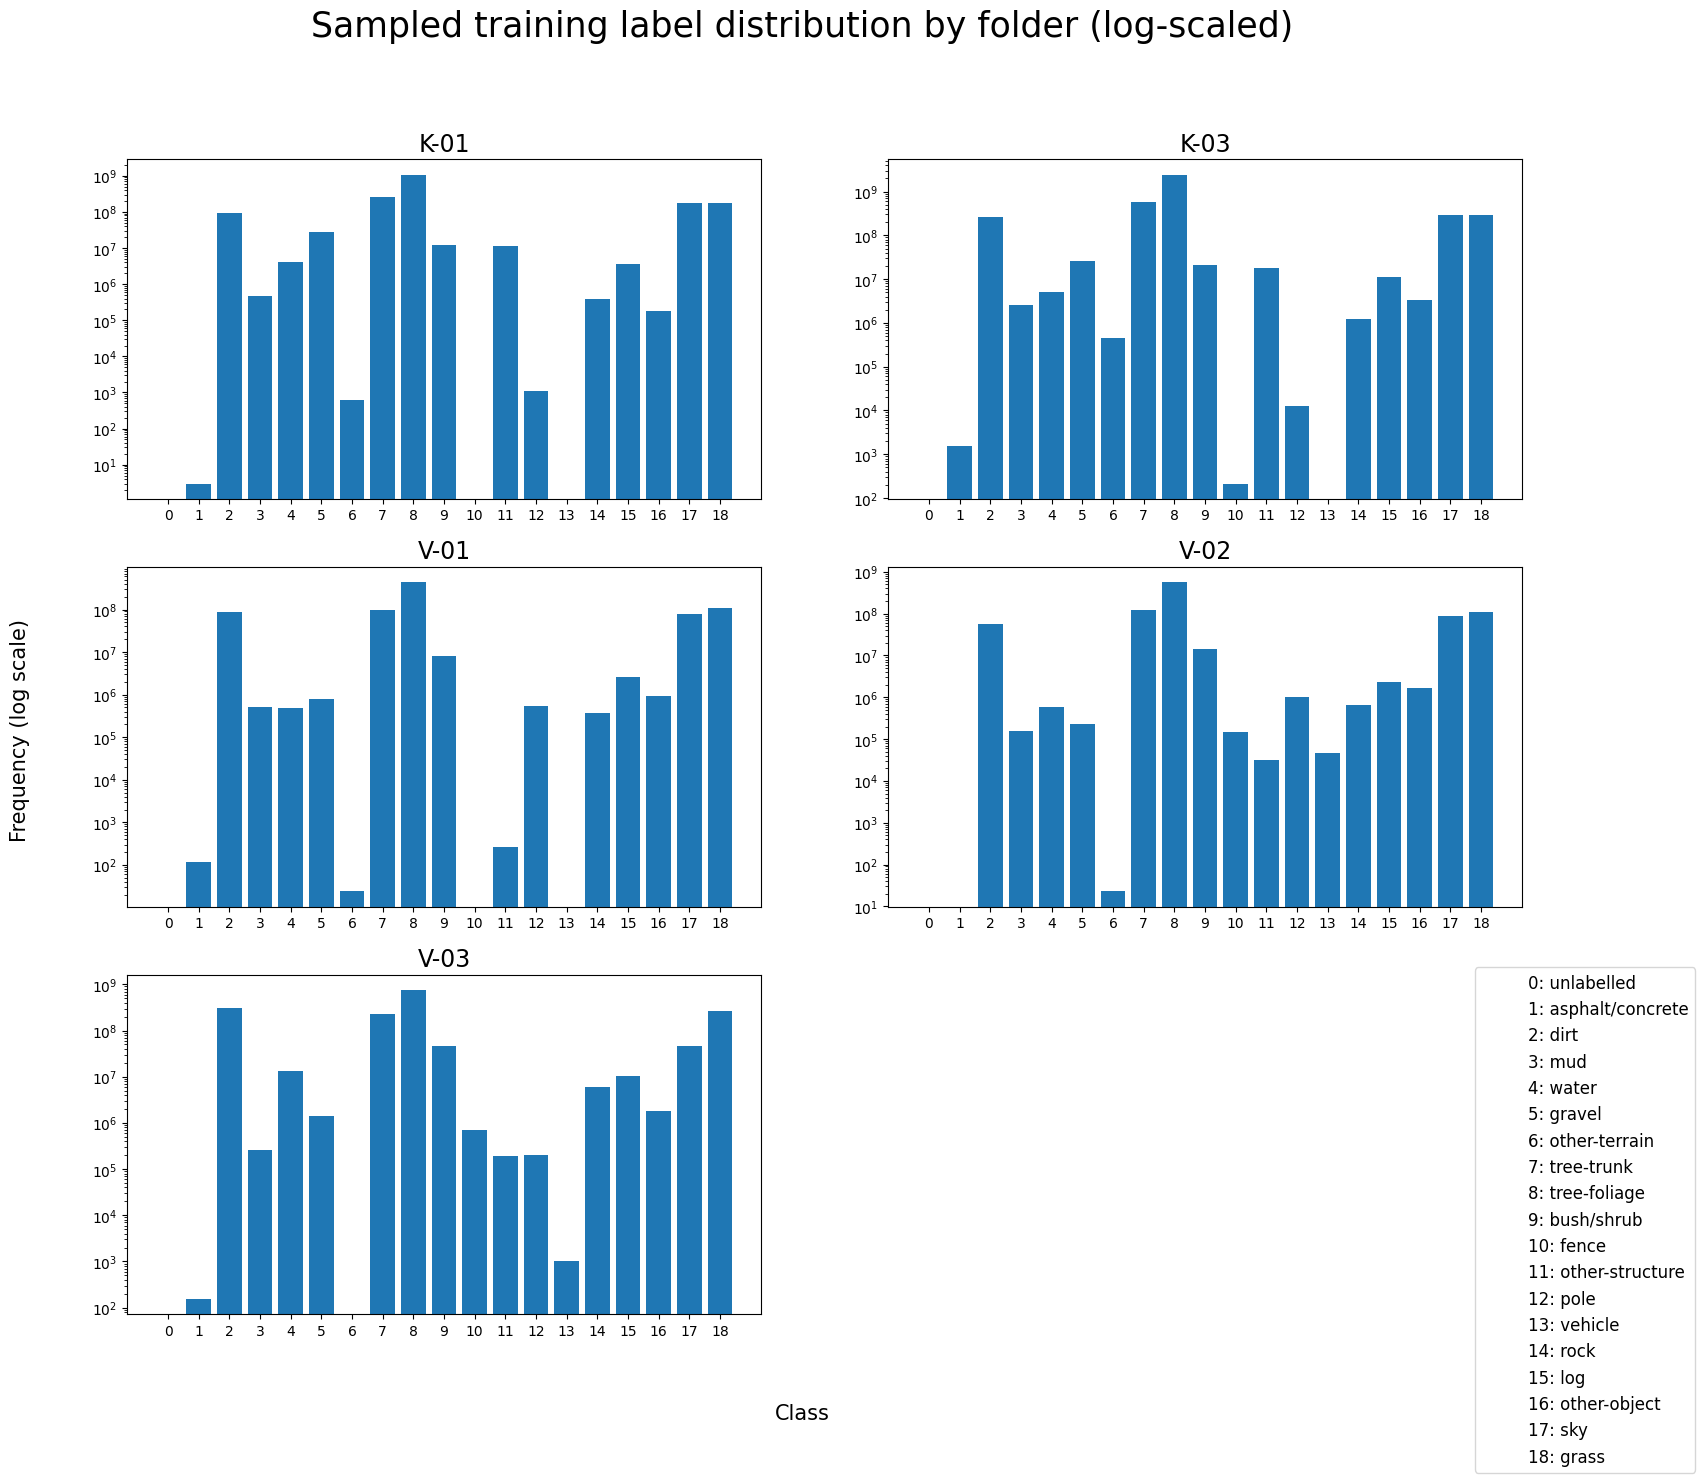

In [549]:
plot_multiple_distributions(
    train_folder_labels_sampled,
    "Sampled training label distribution by folder",
    subtitles=subdirectories,
    labels=id_labels,
    x_axis_factor=1.2,
)

# 4. Validate Re-Sampling

### **Stratified Additive Sampling by Label Distribution**

In [171]:
def get_val_from_unsampled(
    val_lb_dist    ,  # val set label distribution
    dataset_labels ,  # whole set label distribution
    df             ,  # dataframe to sample additional val entries from
    idx_sampled    ,  # already sampled entry indices from df to avoid
    min_labels     ,  # labels which need more samples for val set
    n_iter=2       ,  # num iterations to cut off before distribution convergence
    lb_iter=4      ,  # num images to sample from per label before cutoff
    margin=1e3     ,  # soft margin before label sample cutoff
    seed=100       ,  # random seed
):
    sampled_indices    = np.array(range(len(df)))
    unsampled_mask     = np.isin(sampled_indices, idx_sampled, invert=True)
    unsampled_indices  = sampled_indices[unsampled_mask]
    unsampled_set      = np.array(df['label_path'])[unsampled_indices]
    label_distribution = lambda label: np.bincount(label.flatten(), minlength=NUM_CLASSES)

    # function to check whether an image has each of the specified labels in provided list
    has_label = lambda lst, arr: {n: np.isin(n, arr) for n in lst}

    # function to assign an image to its label, in other words, group by label
    def group_assign(idx, dist, gb, grp):
        for i in gb:  # check if for each min label i
            if gb[i]: # is in indexed image idx
                grp[i].append((idx, dist[i])) # add only distribution of label i

    # group by labels
    min_groups = {i: [] for i in min_labels}
    for idx, label_path in zip(unsampled_indices, unsampled_set):
        image = cv2.imread(label_path, -1)
        group = has_label(min_labels, image)
        dist  = label_distribution(image)
        group_assign(idx, dist, group, min_groups)

    # get proportions
    proportions = {i: dataset_labels[i] / np.max(dataset_labels) for i in min_labels}
    np.random.seed(seed)

    # randomly pick until end of iteration or convergence
    i = 0
    selected = []
    px_by_label = {i: 0 for i in min_labels}
    
    for i in range(n_iter):
        # allow duplicate selection across classes, improving randomization
        for min_label in min_labels:
            label_set = np.array(min_groups[min_label])
            required_num_pixels = int(
                proportions[min_label] * np.max(val_lb_dist) - val_lb_dist[min_label]
            )

            # n is the current number of pixels for min label at hand
            n = px_by_label[min_label]
            # ensuring that n has not exceeded required number of pixels
            if len(label_set) == 0 or n >= required_num_pixels:
                continue

            j = 0
            selected_for_label = []
            while j < lb_iter and n < required_num_pixels and len(label_set) > 0:
                # shuffle and take first as sample
                np.random.shuffle(label_set)
                sample, sample_dist = label_set[0]
                if n + sample_dist >= required_num_pixels - margin:
                    break
                selected_for_label.append(sample)
                label_set = label_set[1:]
                # then, add the added number of pixels to n
                n += sample_dist
                j += 1

            px_by_label[min_label] = n
            min_groups[min_label] = label_set
            selected.extend(selected_for_label)

        # remove duplicates, and check for convergence
        selected = list(set(selected))
    return selected

### **Results**

In [166]:
min_val_labels = [1,3,4,6,10,12,13]
val_sampled = get_val_from_unsampled(
    val_labels, dataset_labels, train_df, train_indx_sampled, min_val_labels
)

val_sample_df = pd.concat([val_df, train_df.iloc[val_sampled]], axis=0, ignore_index=True)
val_sample_labels = label_distributions(METAINFO['classes'], arr=label_arr(val_sample_df))

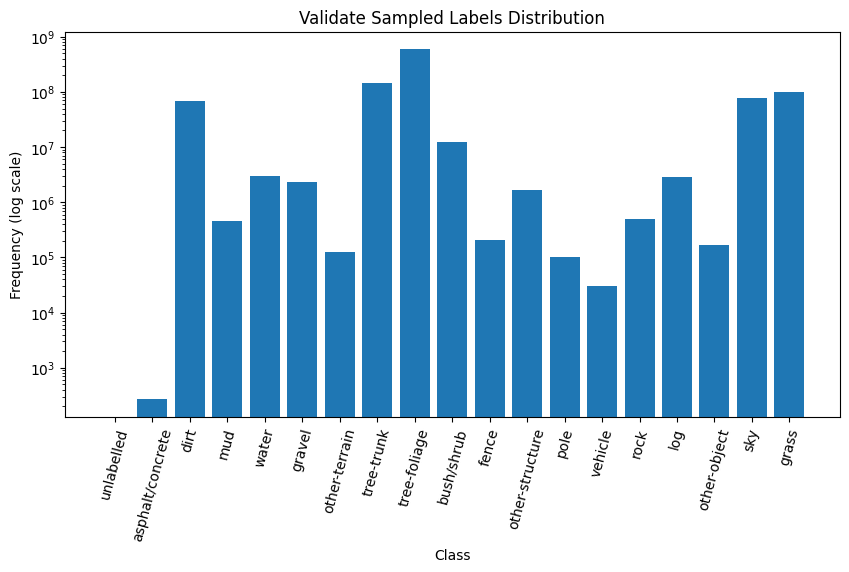

In [167]:
plot_distribution(val_sample_labels, 'Validate Sampled Labels Distribution', METAINFO['classes'], log=True)

In [504]:
print_sampling_info(train_labels, train_labels_sampled2, "train", id_labels, print_log=0)

Comparative label distribution between Original and Sampled for train set (frac = 0.5)

Normal-scaled
-------------------------------------------------------
		 Original 	Sampled 	Score
unlabelled	 0.0		0.0		0
asphalt/concrete 1794.0		1794.0		0.0
dirt		 1600840094.0	818554872.0	0.9773
mud		 6857813.0	3343521.0	0.9751
water		 48116742.0	25238762.0	0.9509
gravel		 103405446.0	49677254.0	0.9608
other-terrain	 860988.0	413572.0	0.9607
tree-trunk	 2639454701.0	1308147097.0	0.9912
tree-foliage	 10507673624.0	5224512509.0	0.9944
bush/shrub	 203633644.0	105305092.0	0.9657
fence		 1620768.0	882559.0	0.9109
other-structure	 60550301.0	27658051.0	0.9136
pole		 3377421.0	1596758.0	0.9455
vehicle		 118755.0	74996.0		0.737
rock		 14315444.0	7242737.0	0.9881
log		 65429710.0	32548243.0	0.9949
other-object	 15645583.0	7202479.0	0.9207
sky		 1350206976.0	682663290.0	0.9888
grass		 1822499988.0	925717214.0	0.9841
Total		 18444609792.0	9220780800.0	0.9998


### Saving sample CSV

In [156]:
train_sample_df = train_df.iloc[train_indx_sampled]
train_sample_df.to_csv('train_sample_30.csv', index=False)
val_sample_df.to_csv('val_sample_30.csv', index=False)

# train_sample_df2 = train_df.iloc[train_indx_sampled2]
# train_sample_df2.to_csv('train_sample2.csv', index=False)